# Analiza glavnih komponenti

Analiza glavnih komponenti (engl. *principal component analysis*, skraćeno *PCA*) je statistička procedura koja se koristi za redukciju dimenzionalnosti. Smanjena dimenzionalnost je od značaja u zadacima interpretacije i vizuelizacije podataka, ali i kod optimalnijeg korišćenja računskih resursa. Sama procedura je nenadgledanog karaktera i ne zahteva poznavanje obeležja posmatranih instanci. 

PCA preslikava polazni skup atributa u novi skup atributa koristeći informaciju o varijansi atributa. Svaki od atributa novog skupa se naziva `glavnom komponentom`. Prva glavna komponenta se bira tako da ima najveću moguću varijansu tj. bira se tako da duž nje podaci najviše variraju. Svaka naredna glavna komponenta se bira tako da je normalna na sve prethodne komponente i da, takođe, trenutno ima najveću varijansu. 

<img src='assets/PCA.gif'>
Na slici, položaj vektora obeleženog ljubičastim markerima odgovara prvoj glavnoj komponenti.

U zavisnosti od broja odabranih glavnih komponenti, zavisi i gubitak informacija iz polaznog skupa. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from sklearn import preprocessing
from sklearn import datasets
from sklearn import decomposition

Prvim primerom ćemo proći kroz manuelnu implementaciju glavnih koraka PCA procedure, a potom ćemo upoznati bibliotečku podršku.

Skup podataka sa kojim ćemo raditi sadrži podatke o tumorima dojke. Na raspolaganju su vrednosti 30 različitih atributa među kojima su opis teksture tumora, njegove kompaktnosti, površine, glatkosti, simetrije, itd. Informacija je dostupna za 569 pacijenata. Uz opise tumora, prisutna je i informacija o tome da li je tumor benigan ili maligan. 

Skup podataka se može učitati pozivom `load_breast_cancer()` iz `sklearn.datasets` paketa. 

In [3]:
data = datasets.load_breast_cancer()

Instance sa kojima radimo ćemo čuvati u matrici `X`. Kolone ove matrice predstavljaju vrednosti pojedinačnih atributa.

In [4]:
X = data.data
number_of_features = data.data.shape[1]

In [5]:
print('Broj atributa: ', number_of_features)

Broj atributa:  30


Obeležja koja su pridružena instancama ćemo čuvati na nivou vektora `y`. Vrednost `0` označava maligni tumor, a vrednost `1` benigni. 

In [6]:
y = data.target
number_of_classes = np.unique(y).shape[0]

In [7]:
print('Broj klasa: ', number_of_classes)

Broj klasa:  2


Više o atributima skupa možemo pročitati ispisivanjem detaljnog opisa `print(data.DESCR)`.

In [8]:
# print(data.DESCR)

Dalje ćemo proći kroz korake PCA tehnike.

### Primer redukcije dimenzionalnosti, manuelna implementacija

#### 1. korak: standardizacija skupa podataka

Kako PCA tehnika posmatra varijansu pojedinačnih atributa, ukoliko atributi imaju različite skale vrednosti ima smisla izvršiti pripremu, tj. standardizaciju njihovih vrednosti.  

Prvo možemo dati uvid u srednju vrednost i varijansu atributa originalnog skupa, zatim izvršiti njegovu standardizaciju, a potom prikazati i srednju vrednost i varijansu u modifikovanom skupu.

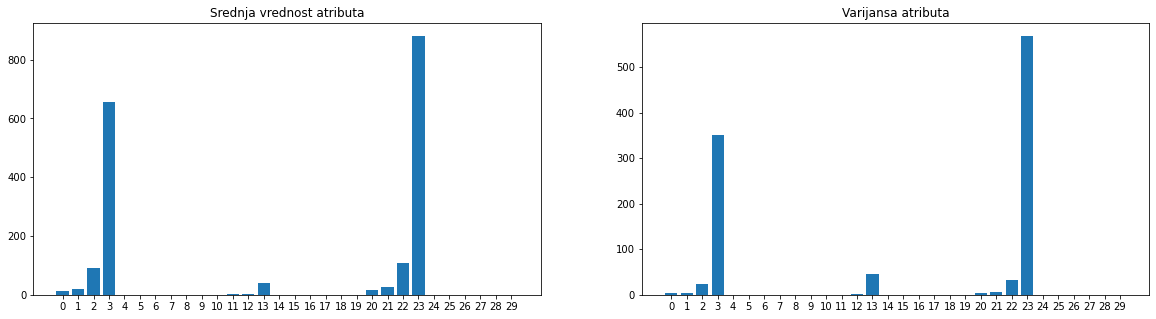

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.set_title('Srednja vrednost atributa')
ax1.set_xticks(np.arange(0, number_of_features))
ax1.bar(np.arange(0, number_of_features), X.mean(axis=0))

ax2.set_title('Varijansa atributa')
ax2.set_xticks(np.arange(0, number_of_features))
ax2.bar(np.arange(0, number_of_features), X.std(axis=0))

plt.show()

In [10]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X-X_mean)/X_std

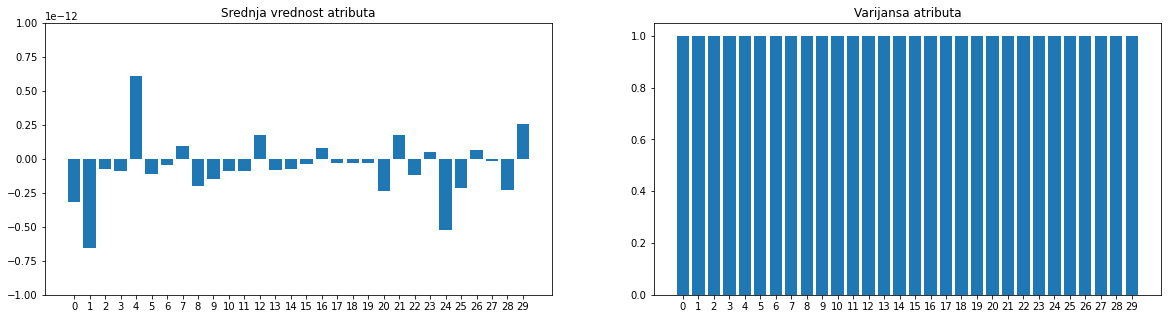

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.set_title('Srednja vrednost atributa')
ax1.set_xticks(np.arange(0, number_of_features))
ax1.bar(np.arange(0, number_of_features), X.mean(axis=0)*100)

ax2.set_title('Varijansa atributa')
ax2.set_xticks(np.arange(0, number_of_features))
ax2.bar(np.arange(0, number_of_features), X.std(axis=0))

plt.show()

#### 2. korak: kreiranje matrice kovarijanse

Kovarijansa je mera koja nam daje uvid u povezanost dveju veličina. Baš kao što varijansa daje informaciju o varijabilnost jedne veličine, tako kovarijansa daje informaciju o uzajamnoj varijabilnosti dveju veličina. 

Ako su $X_j$ i $X_k$ dve veličine tj. dva atributa koja posmatramo, kovarijansa između njih se računa po formuli $$\sigma_{jk}=\frac{1}{N-1}\sum_{i=1}^{N}(x_{ij}-\bar{x_{j}})(x_{ik}-\bar{x_{k}})$$ gde $\bar{x_{j}}$ i $\bar{x_{k}}$ predstavljaju srednju vrednost atributa $X_j$ i $X_k$, a $N$ njihovu dimenziju. Vektorski, ova izračunavanja možemo zapisati kao $$\sigma_{jk}=\frac{1}{N-1}(X_j - \bar{x_{j}})^T \cdot (X_k - \bar{x_{k}}))$$.

Za kreiranje matrice kovarijanse možemo iskoristiti podršku `numpy` biblioteke kroz funkciju `cov`. Argument funkcije `cov` je matrica čije vrste sadrže vrednosti pojedinačnih atributa. 

In [13]:
covariance_matrix = np.cov(X.T)

#### 3. korak: određivanje sopstvenih vrednosti i sopstvenih vektora matrice kovarijanse

Sopstvene vektore matrice kovarijanse nazivamo `glavnim komponentama`. Glavne komponente određuju pravac novog prostora atributa, dok sopstvene vrednosti određuju njihovu vrednost. Možemo reći i da sopstvene vrednosti objašnjavaju varijansu podataka duž pravaca novih atributa.

Za određivanje sopstvenih vrednosti i sopstvenih vektora matrice kovarijanse možemo iskoristiti funkciju `eig`. Podsetimo se da izračunati sopstveni vektori predstavljaju kolone rezultujuće matrice.

In [14]:
eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

#### 4. korak: uređivanje skupa sopstvenih vrednosti po veličini, od najveće ka najmanjoj 

Svi izračunati sopstveni vektori imaju jediničnu normu. Da bismo odredili vektore koje možemo odbaciti bez previše gubitka informacija posmatramo njima pridružene sopstvene vrednosti. Sopstvene vrednosti se mogu interpretirati kao dužine ili magniture odgovarajućih sopstvenih vektora. Sopstveni vektori sa najmanjim sopstvenim vrednostima nose najmanje informacija o distribuciji podataka pa su oni kandidati za eleminaciju. Zato je sledeći korak sortiranje sopstvenih vektora prema vrednostima sopstvenih vrednosti u opadajućem poretku.

In [15]:
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:,i]) for i in range(0, len(eig_values))]
eig_pairs.sort(reverse=True)

#### 5.korak: kreiranje matrice transformacije

Matrica transformacije je matrica kojom se polazni skup atributa svodi na nove, glavne, komponente. Nju kreiramo izdvajanjem `k` sopstvenih vektora koji odgovaraju najvećim sopstvenim vrednostima. Izdvojeni vektori treba da predstavljaju kolone matrice transformacije. Izbor parametra `k` određuje dimenziju novog prostora atributa.  

In [16]:
k = 2

In [17]:
transformation_matrix = np.empty((number_of_features, k))
for i in range(0, k):
    transformation_matrix[:, i] = eig_pairs[i][1] 

O izboru vrednosti broja `k` će biti još reči.

#### 6.korak: transformacija polaznog skupa atributa

Poslednji korak PCA tehnike je transformisanje polaznog skupa atributa u novi skup koji je određen glavnim komponentama. Novi skup atributa se dobija množenjem matrice transformacija i polaznog skupa. 

In [18]:
X_transformed = transformation_matrix.T.dot(X.T).T

In [19]:
X_transformed.shape

(569, 2)

Pošto smo koristili svođenje na skup atributa dimenzije dva novodobijene podatke sada lako možemo vizualizovati. 

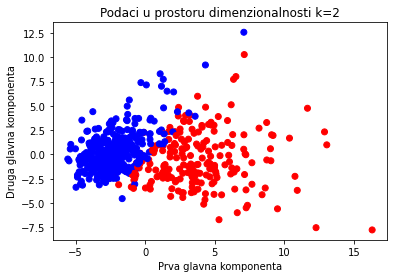

In [20]:
colors = ['red' if v == 0 else 'blue' for v in y]
labels = ['malignant', 'benign']
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=colors)
plt.title('Podaci u prostoru dimenzionalnosti k=2')
plt.xlabel('Prva glavna komponenta')
plt.ylabel('Druga glavna komponenta')
plt.show()

### Primer redukcije dimenzionalnosti, bibliotečka podrška

Ponovo ćemo učitati podatke za dalji rad.

In [21]:
X = data.data
number_of_features = data.data.shape[1]

Najpre ćemo, kao ulaz u algoritam, izvršiti standardizaciju podataka korišćenjem `StandardScaler` klase paketa `sklearn.preprocessing`.

Biblioteka stavlja na raspolaganje klasu `PCA` paketa `sklearn.decomposition` kojom se može izvršiti redukcija dimenzionalnosti korišćenjem glavnih komponenti. Očekivani parametar je broj glavnih komponenti `n_components`. Mi ćemo polazni skup podataka transformisati tako da ima dve glavne komponente.

Kako imamo samo dve glavne komponente, transformisani dvodimenzionalni prostor se može jednostavno predstaviti u ravni. Prva kolona matrice `X_pca` se odnosi na prvu glavnu komponentu i njene vrednosti će biti predstavljene na *x*-osi, a druga kolona se odnosu na drugu glavnu komponentu i njene vrednosti će biti predstavljene na _y_-osi. Kako imamo samo dve ciljne klase, vrednosti ciljne promenljive su 0 ili 1. Tačke za koje je $y = 0$ ćemo obojiti crvenom, a tačke za koje je $y = 1$ plavom bojom. 

Matrica `pca.components_` sadrži informacije o međusobnom odnosu svakog od polaznih atributa i dobijenih glavnih komponenti. Ovo možemo iskoristiti za prikazivanje zavisnosti u formi toplotne mape. Prvi red će se odnosi na prvu, a drugi na drugu glavnu komponentu. Svaki od atributa je opisan pojedinačnom kolonom.

Atributom `explained_variance_ratio_` možemo odrediti količinu varijanse podataka koje svaka od glavnih komponenti objašnjava.

Važno pitanje je kako odrediti polazne atribute ukoliko poznajemo vrednosti atributa u novom prostoru. Funkcija `inverse_transform` omogućava ovu vrstu izračunavanja. Na primer, instanci (5, 2.5) odgovara sledeće vektor polaznog skupa atributa: